In [1]:
pip install -e ./gym_foo

Obtaining file:///Users/akshatsharma/Desktop/Courses/CS698R/Assignment-1/gym_foo
  Attempting uninstall: gym-foo
    Found existing installation: gym-foo 0.0.1
    Uninstalling gym-foo-0.0.1:
      Successfully uninstalled gym-foo-0.0.1
  Running setup.py develop for gym-foo
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
from gym import Env
from gym.spaces import Discrete
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

seed=130
np.random.seed(seed)

Part 1

In [3]:
def generateTrajectory(env, policy, maxSteps):
    exp_tuples_list=[]
    for i in range(maxSteps):
        current_state = env.state
        action = policy[current_state]
        next_state, reward, done = env.step(action)
        exp_tuples_list.append([current_state, action, reward, next_state])

        if(done):
            env.reset()
            return exp_tuples_list
      
    env.reset()
    return []

In [4]:
policy={}
for i in range(1,6):
  policy[i]=0

env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)

for i in range(10):
  print(generateTrajectory(env, policy, 10))

[[3, 0, 0, 2], [2, 0, 0, 1], [1, 0, 0, 2], [2, 0, 0, 1], [1, 0, 0, 0]]
[]
[[3, 0, 0, 2], [2, 0, 0, 1], [1, 0, 0, 2], [2, 0, 0, 3], [3, 0, 0, 4], [4, 0, 0, 5], [5, 0, 0, 4], [4, 0, 0, 5], [5, 0, 1, 6]]
[[3, 0, 0, 2], [2, 0, 0, 1], [1, 0, 0, 0]]
[[3, 0, 0, 4], [4, 0, 0, 5], [5, 0, 1, 6]]
[]
[]
[[3, 0, 0, 4], [4, 0, 0, 5], [5, 0, 1, 6]]
[]
[]


Part 2

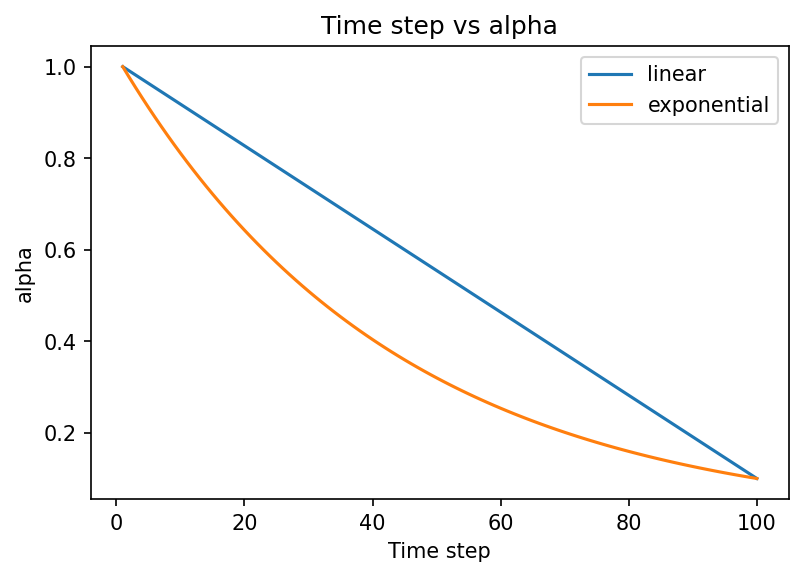

In [5]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType):
    if(decayType == "linear"):
        decay_rate = (finalValue-initialValue)/(maxSteps-1)
        parameter_list = []
        for i in range(1,maxSteps+1):
          parameter_list.append(initialValue + (i-1)*decay_rate)
        return parameter_list

    elif(decayType == "exponential"):
        decay_rate = -1.0/(maxSteps-1)*np.log(finalValue/initialValue)
        parameter_list = []
        for i in range(0,maxSteps):
          parameter_list.append(initialValue*np.exp(-1.0*decay_rate*i))
        return parameter_list

#decay plots
parameter_list_linear = decayAlpha(1,0.1,100,"linear")
parameter_list_exp = decayAlpha(1,0.1,100,"exponential")
plt.figure(dpi=150)
plt.plot(range(1,1+len(parameter_list_linear)), parameter_list_linear, label="linear")
plt.plot(range(1,1+len(parameter_list_exp)), parameter_list_exp, label="exponential")
plt.xlabel("Time step")
plt.ylabel("alpha")
plt.title("Time step vs alpha")
plt.legend()
plt.savefig("./plots/Q2/Time step vs alpha.png")
plt.show()
plt.close()

Part 3

In [6]:
def MonteCarloPrediction(env, policy, maxSteps, noEpisodes, firstVisit, print_trajectory=False, return_targets=False):
  v = np.zeros(7) #states 1-5 are of interest
  v_book_keeping = np.zeros((noEpisodes,7))
  target_book_keeping = np.zeros((noEpisodes,7))
  parameter_list = decayAlpha(0.5, 0.01, 250, "exponential")
  if(noEpisodes>250):
    parameter_list = parameter_list + [0.01 for i in range(noEpisodes-250)]

  for episode in range(noEpisodes):
    alpha = parameter_list[episode]
    # print("episode is {}, alpha is {}".format(episode, alpha))
    t = generateTrajectory(env, policy, maxSteps)
    if(print_trajectory):
      print("Episode {} : trajectory {}".format(episode, t))

    visited = np.zeros(7)
    for i, exp_tuple in enumerate(t):
      s,a,r,s_ = exp_tuple
      if(visited[s]==1 and firstVisit):
        continue
      
      #find G
      G=0
      for j in range(i,len(t)):
        G += t[j][2]
      target_book_keeping[episode][s] = G

      #update equation
      v[s] = v[s] + alpha*(G-v[s])
    
      #mark s as visited
      visited[s] = 1
    
    v_book_keeping[episode] = v
    
  if return_targets:
    return v, v_book_keeping, target_book_keeping
  return v, v_book_keeping

#test case
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping = MonteCarloPrediction(env, policy, 20, 1, firstVisit = True, print_trajectory = True)
print(v)

Episode 0 : trajectory [[3, 0, 0, 4], [4, 0, 0, 5], [5, 0, 1, 6]]
[0.  0.  0.  0.5 0.5 0.5 0. ]


Part 4

In [7]:
def TemporalDifferencePrediction(env, policy, noEpisodes, print_trajectory=False, return_targets=False):
  v = np.zeros(7) #states 1-5 are of interest
  v_book_keeping = np.zeros((noEpisodes,7))
  target_book_keeping = np.zeros((noEpisodes,7))
  parameter_list = decayAlpha(0.5, 0.01, 250, "exponential")
  if(noEpisodes>250):
    parameter_list = parameter_list + [0.01 for i in range(noEpisodes-250)]

  for episode in range(noEpisodes):
    alpha = parameter_list[episode]
    # print("episode is {}, alpha is {:0.3f}".format(episode, alpha))
    env.reset()
    done=False
    while(not done):
      current_state = env.state
      a = policy[current_state]
      s_, r, done = env.step(a)
      td_target = r
      if not done:
        td_target += v[s_]
      td_error = td_target - v[current_state]
      v[current_state] += alpha*td_error
      target_book_keeping[episode][current_state] = td_target
    
    v_book_keeping[episode] = v

  if(return_targets):
    return v, v_book_keeping, target_book_keeping
  return v, v_book_keeping

#test case
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping = TemporalDifferencePrediction(env, policy, 500)
print(v)

[0.         0.14599387 0.30575401 0.48638312 0.66874417 0.82994873
 0.        ]


Part 5 and 8

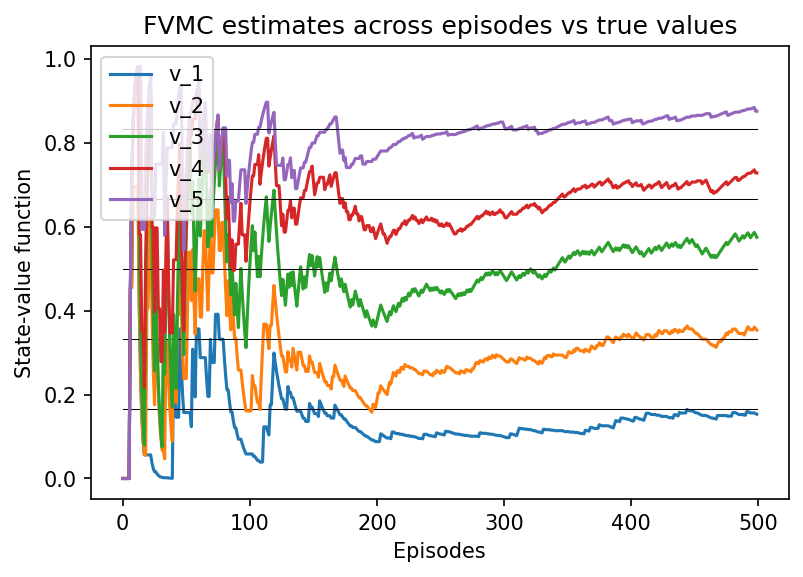

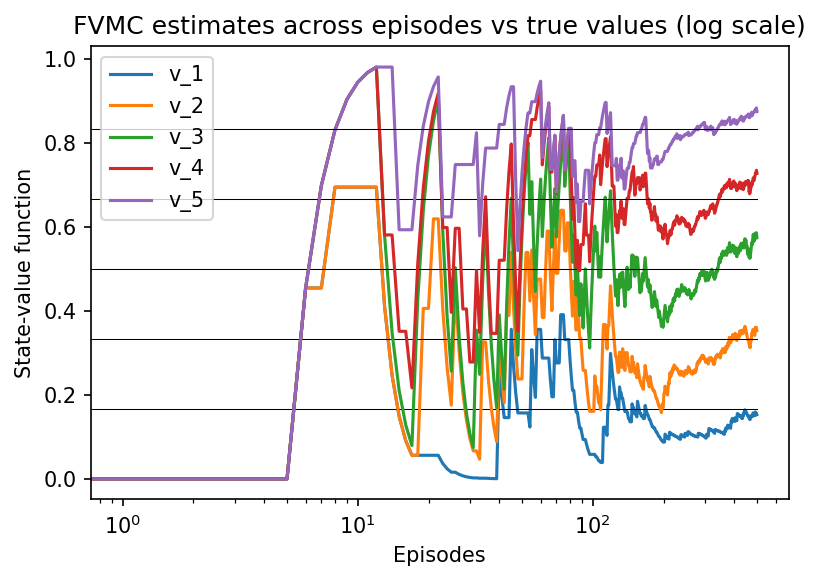

In [8]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping = MonteCarloPrediction(env, policy, 1000, 500, firstVisit = True)

plt.figure(dpi=150)
#plot v_book_keeping aptly
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))], color = 'black', linewidth=0.5 )

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.title("FVMC estimates across episodes vs true values")
plt.legend()
plt.savefig("./plots/Q2/FVMC estimates across episodes vs true values.png")
plt.show()
plt.close()

plt.figure(dpi=150)
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))], color = 'black', linewidth=0.5)

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.xscale("log")
plt.title("FVMC estimates across episodes vs true values (log scale)")
plt.legend()
plt.savefig("./plots/Q2/FVMC estimates across episodes vs true values (log scale).png")
plt.show()
plt.close()

Part 6 and 9

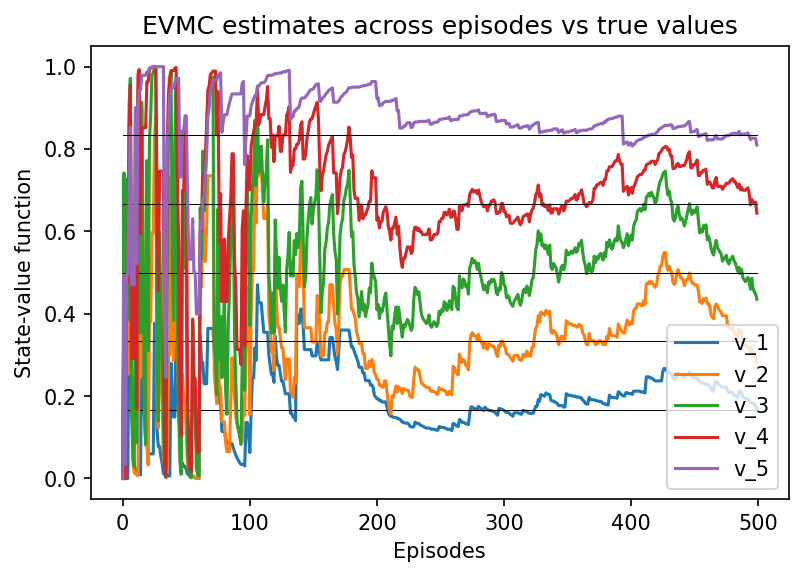

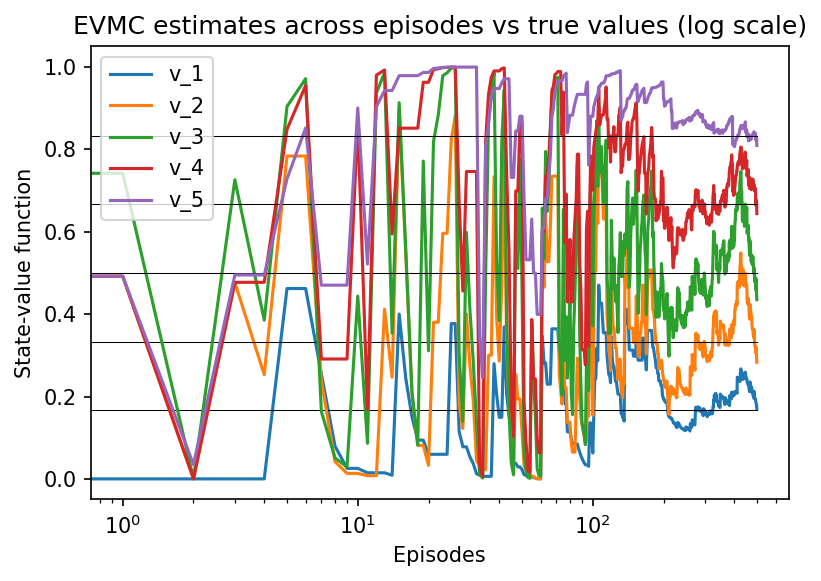

In [9]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping = MonteCarloPrediction(env, policy, 1000, 500, firstVisit = False)

plt.figure(dpi=150)
#plot v_book_keeping aptly
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))] ,color = 'black', linewidth=0.5)

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.title("EVMC estimates across episodes vs true values")
plt.legend()
plt.savefig("./plots/Q2/EVMC estimates across episodes vs true values.png")
plt.show()
plt.close()

plt.figure(dpi=150)
#plot v_book_keeping aptly
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))] ,color = 'black', linewidth=0.5)

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.xscale("log")
plt.title("EVMC estimates across episodes vs true values (log scale)")
plt.legend()
plt.savefig("./plots/Q2/EVMC estimates across episodes vs true values (log scale).png")
plt.show()
plt.close()

Part 7 and 10

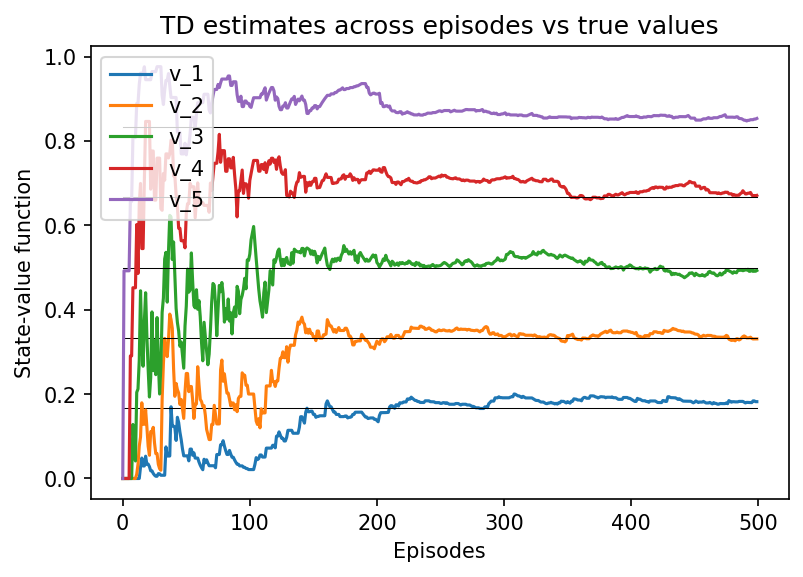

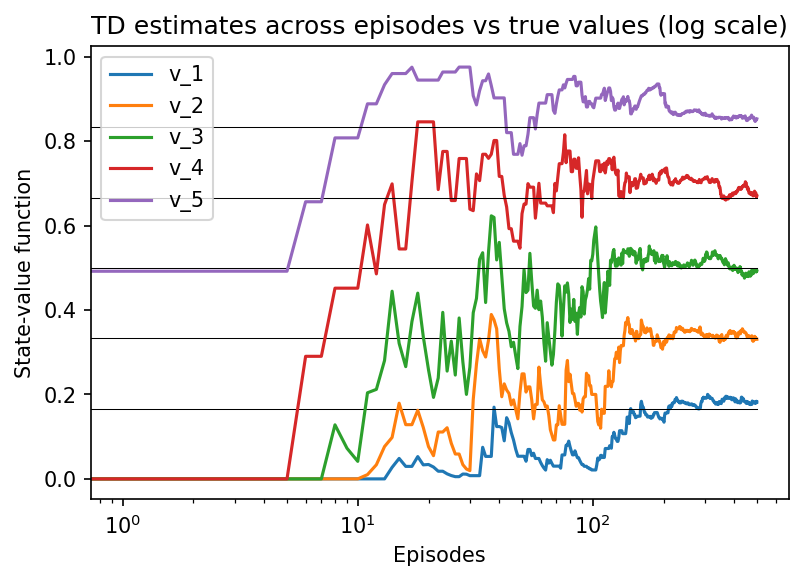

In [10]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping = TemporalDifferencePrediction(env, policy, 500)

plt.figure(dpi=150)
#plot v_book_keeping aptly
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))],color = 'black', linewidth=0.5 )

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.title("TD estimates across episodes vs true values")
plt.legend()
plt.savefig("./plots/Q2/TD estimates across episodes vs true values.png")
plt.show()
plt.close()

plt.figure(dpi=150)
#plot v_book_keeping aptly
for i in range(1,6):
  state_valuation = v_book_keeping[:,i]
  plt.plot(range(len(state_valuation)), state_valuation, label="v_{}".format(i))
  plt.plot(range(len(state_valuation)), [i/6 for k in range(len(state_valuation))],color = 'black', linewidth=0.5 )

#set plot
plt.xlabel("Episodes")
plt.ylabel("State-value function")
plt.xscale("log")
plt.title("TD estimates across episodes vs true values (log scale)")
plt.legend()
plt.savefig("./plots/Q2/TD estimates across episodes vs true values (log scale).png")
plt.show()
plt.close()

Part 12 : MC-FVMC Target value for State 3

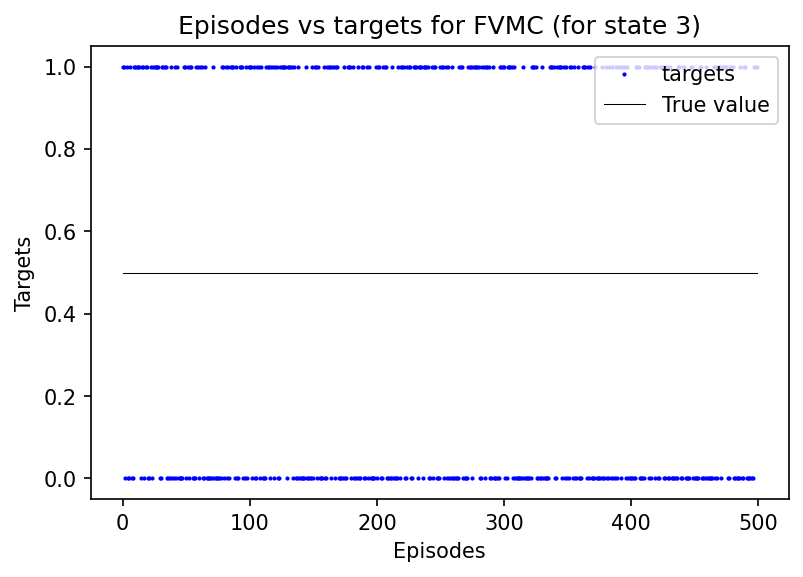

In [11]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping, target_book_keeping = MonteCarloPrediction(env, policy, 1000, 500, firstVisit=True, return_targets=True)

plt.figure(dpi=150)
plt.plot(target_book_keeping[:,3], 'bo', markersize=1, label="targets")
plt.plot([3/6 for i in range(len(target_book_keeping[:,3]))], label="True value", linewidth = 0.5, color='black')
plt.xlabel("Episodes")
plt.ylabel("Targets")
plt.title("Episodes vs targets for FVMC (for state 3)")
plt.legend()
plt.savefig("./plots/Q2/Episodes vs targets for FVMC (for state 3).png")
plt.show()
plt.close()

Part 13 : MC-FVMC Target value for State 3

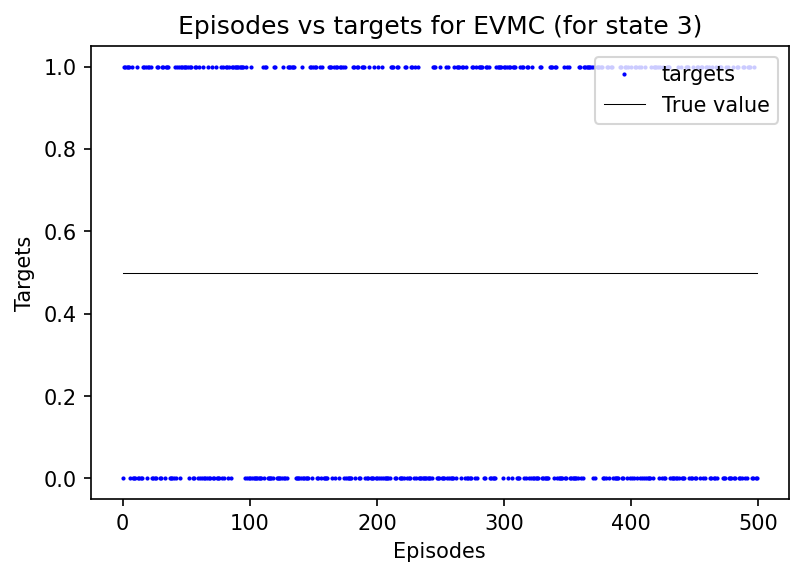

In [12]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping, target_book_keeping = MonteCarloPrediction(env, policy, 1000, 500, firstVisit=False, return_targets=True)

plt.figure(dpi=150)
plt.plot(target_book_keeping[:,3], 'bo', markersize=1, label="targets")
plt.plot([3/6 for i in range(len(target_book_keeping[:,3]))], label="True value", linewidth = 0.5, color='black')
plt.xlabel("Episodes")
plt.ylabel("Targets")
plt.title("Episodes vs targets for EVMC (for state 3)")
plt.legend()
plt.savefig("./plots/Q2/Episodes vs targets for EVMC (for state 3).png")
plt.show()
plt.close()

Part 14 : TD Target value for State 3

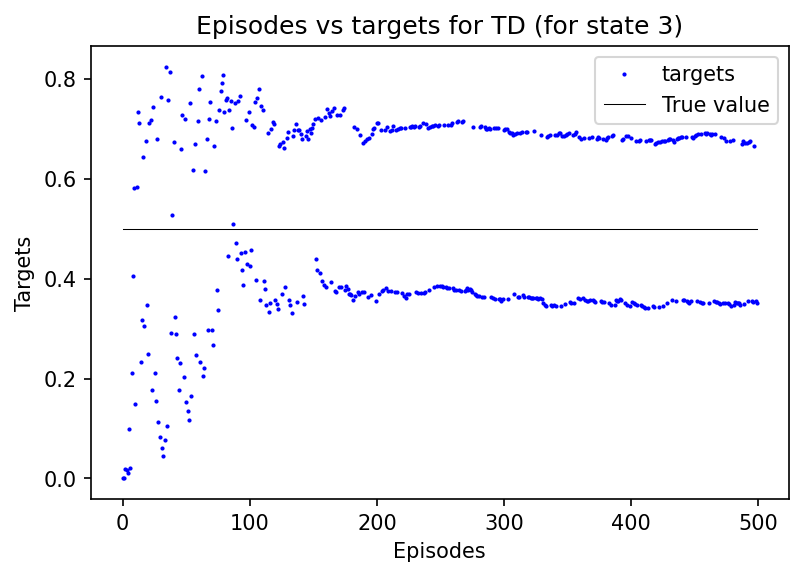

In [13]:
env = gym.make("gym_foo:Random_Walk-v0")
env.__init__(set_seed = seed)
v, v_book_keeping, target_book_keeping = TemporalDifferencePrediction(env, policy, 500, return_targets=True)

plt.figure(dpi=150)
plt.plot(target_book_keeping[:,3], 'bo', markersize=1, label="targets")
plt.plot([3/6 for i in range(len(target_book_keeping[:,3]))], label="True value", linewidth = 0.5, color='black')
plt.xlabel("Episodes")
plt.ylabel("Targets")
plt.title("Episodes vs targets for TD (for state 3)")
plt.legend()
plt.savefig("./plots/Q2/Episodes vs targets for TD (for state 3).png")
plt.show()
plt.close()